In [53]:
%load_ext autoreload
%autoreload 2

from util_0731 import *
from myalgorithm_0730_1 import algorithm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 실험 내용

- readytime과 deadline을 기준으로 오름/내림차순 정렬한 뒤 처음 주문부터 순회하면서 묶는게 가능한 주문 중 총 비용이 가장 낮은 주문하고 묶음. 이러한 작업을 묶이는 주문이 없을 때까지 반복함.

In [104]:
# problem_file = r'C:\Users\hsh80\Desktop\LG CNS\stage1_problems\STAGE1_5.json'
problem_file = '../alg_test_problems_20240429/TEST_K200_1.json'

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

for v in ALL_RIDERS:
    print(v)

print(K)

Rider([BIKE, 5.291005291005291, 100, 60, 5000, 120, 40])
Rider([WALK, 1.3227513227513228, 70, 30, 5000, 120, 60])
Rider([CAR, 4.2328042328042335, 200, 100, 5000, 180, 200])
200


## 초기 코드

In [125]:
## ------------------- 초기 상태 할당 코드 -------------------------

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

init_availables = [rider.available_number for rider in ALL_RIDERS]

## ------------------  크루스칼 함수   -----------------------------

def kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, order_count_upper_limit, avg_method, all_bundles, default_get_dist_function):
    def find(v):
        while v != parent[v]:
            parent[v] = parent[parent[v]]
            v = parent[v]

        return v

    def union(a, b, new_bundle):
        if a > b:
            a, b = b, a

        parent[b] = a
        all_bundles[a] = new_bundle

    for i in range(len(all_bundles)):
        bundle = all_bundles[i]

        shop_seq = bundle.shop_seq

        xs_s_sum = 0
        ys_s_sum = 0

        xs_e_sum = 0
        ys_e_sum = 0

        readytimes_sum = 0
        deadlines_sum = 0

        shop_seq_len = len(shop_seq)

        for order_num in shop_seq:
            order = ALL_ORDERS[order_num]

            xs_s_sum += order.shop_lat
            ys_s_sum += order.shop_lon

            xs_e_sum += order.dlv_lat
            ys_e_sum += order.dlv_lon

            readytimes_sum += order.ready_time
            deadlines_sum += order.deadline

        xs_s_avg = xs_s_sum / shop_seq_len
        ys_s_avg = ys_s_sum / shop_seq_len

        xs_e_avg = xs_e_sum / shop_seq_len
        ys_e_avg = ys_e_sum / shop_seq_len

        readytimes_avg = readytimes_sum / shop_seq_len
        deadlines_avg = deadlines_sum / shop_seq_len

        avg_info = [xs_s_avg, ys_s_avg, xs_e_avg, ys_e_avg, readytimes_avg, deadlines_avg]

        bundle.avg_info = avg_info

    edges = []
    for i in range(len(all_bundles)):
        for j in range(i + 1, len(all_bundles)):
            avg_info1 = all_bundles[i].avg_info
            avg_info2 = all_bundles[j].avg_info

            sx1, sy1, ex1, ey1, r1, d1 = avg_info1
            sx2, sy2, ex2, ey2, r2, d2 = avg_info2

            r_diff = abs(r1 - r2)
            d_diff = abs(d1 - d2)

            start_end_diff = default_get_dist_function((sx1 + sx2) / 2, (sy1 + sy2) / 2, (ex1 + ex2) / 2, (ey1 + ey2) / 2)

            if avg_method == 'avg':
                dist1 = default_get_dist_function(sx1, sy1, sx2, sy2)
                dist2 = default_get_dist_function(ex1, ey1, ex2, ey2)
            elif avg_method == 'two_seq':
                dist1 = DIST[i][j]
                dist2 = DIST[i + K][j + K]
            elif avg_method == 'two':
                order_num1 = all_bundles[i].shop_seq[0]
                order_num2 = all_bundles[j].shop_seq[0]

                dist1 = DIST[order_num1][order_num2]
                dist2 = DIST[order_num1 + K][order_num2 + K]  
            else:
                assert False

            # weight1 = (dist1 + dist2) / 900

            # diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1 + start_end_diff * weight2
            diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1 + start_end_diff * weight2

            edges.append((i, j, diff_score))

    parent = list(range(len(all_bundles)))
    edges.sort(key=lambda x: x[2])

    for bundle_num1, bundle_num2, diff_score in edges:
        rbn1, rbn2 = find(bundle_num1), find(bundle_num2)

        if rbn1 == rbn2:
            continue

        new_bundle = bundle_merging_function(K, DIST, ALL_ORDERS, ALL_RIDERS, all_bundles[rbn1], all_bundles[rbn2], order_count_upper_limit)

        if new_bundle is not None:
            all_bundles[rbn1].rider.available_number += 1
            all_bundles[rbn2].rider.available_number += 1
            
            new_bundle.rider.available_number -= 1

            union(rbn1, rbn2, new_bundle)

    parent = [find(v) for v in parent]

    result_bundles = [all_bundles[v] for v in set(parent)]
    rider_availables = [rider.available_number for rider in ALL_RIDERS]

    return result_bundles, rider_availables

## --------------- 초기 번들링 최적화 코드 --------------------------

weight1 = 1
weight2 = -1

avg_method = 'two'
bundle_merging_function = try_merging_bundles_by_dist
default_get_dist_function = get_dist_by_coords

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

all_bundles = []
for ord in ALL_ORDERS:
    new_bundle = Bundle(ALL_ORDERS, car_rider, [ord.id], [ord.id], ord.volume, DIST[ord.id, ord.id+K])
    car_rider.available_number -= 1
    all_bundles.append(new_bundle)

# print('#2\n')

# 2개 주문 묶음 생성
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 2, 'two_seq', all_bundles, default_get_dist_function)

# print('#4\n')

# 4개 주문 묶음 생성
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 4, 'avg', all_bundles, default_get_dist_function)

# 2개 이하 주문이 묶인 번들을 전부 푼 다음 다시 생성
new_all_bundles = []
for bundle in all_bundles:
    if len(bundle.shop_seq) >= 3:
        new_all_bundles.append(bundle)
    else:
        old_rider = bundle.rider
        old_rider.available_number += 1
        for order_num in bundle.shop_seq:
            order = ALL_ORDERS[order_num]

            new_bundle = Bundle(ALL_ORDERS, car_rider, [order.id], [order.id], order.volume, DIST[order.id, order.id + K])
            car_rider.available_number -= 1
            new_all_bundles.append(new_bundle)

# print('#remain\n')

all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 3, 'two', new_all_bundles, default_get_dist_function)

## ------------------- 라이더 재배치 -------------------------------

all_bundles, rider_availables = reassign_riders(K, ALL_ORDERS, ALL_RIDERS, DIST, init_availables, all_bundles)
for rider_i in range(3):
    ALL_RIDERS[rider_i].available_number = rider_availables[rider_i]

## -------------- 솔루션 제작 및 실현 가능성 확인 코드 ---------------- 

solution = [
        # rider type, shop_seq, dlv_seq
        [bundle.rider.type, bundle.shop_seq, bundle.dlv_seq]
        for bundle in all_bundles
]

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

checked_solution['avg_cost']

3563.1865

### 2 -> 4로 4번들 묶은 뒤 deadline 오름차순 정렬 그리디 방식으로 나머지를 묶어봄

In [57]:
sort_cris = [
    lambda x: 0,
    lambda x: ALL_ORDERS[x.shop_seq[0]].ready_time,
    lambda x: -ALL_ORDERS[x.shop_seq[0]].ready_time,
    lambda x: ALL_ORDERS[x.shop_seq[0]].deadline,
    lambda x: -ALL_ORDERS[x.shop_seq[0]].deadline,
    lambda x: (ALL_ORDERS[x.shop_seq[0]].deadline - ALL_ORDERS[x.shop_seq[0]].ready_time),
    lambda x: -(ALL_ORDERS[x.shop_seq[0]].deadline - ALL_ORDERS[x.shop_seq[0]].ready_time),
    lambda x: ALL_ORDERS[x.shop_seq[0]].volume,
    lambda x: -ALL_ORDERS[x.shop_seq[0]].volume
]

avg_costs = []
for case_i in range(len(sort_cris)):
    ## ------------------- 초기 상태 할당 코드 -------------------------
    with open(problem_file, 'r') as f:
        prob = json.load(f)

    K = prob['K']

    ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
    ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

    DIST = np.array(prob['DIST'])
    for r in ALL_RIDERS:
        r.T = np.round(DIST/r.speed + r.service_time).astype(int)

    inf = float('inf')

    car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
    bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
    walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

    init_availables = [rider.available_number for rider in ALL_RIDERS]

    ## ------------------  크루스칼 함수   -----------------------------

    def kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, order_count_upper_limit, avg_method, all_bundles, default_get_dist_function):
        def find(v):
            while v != parent[v]:
                parent[v] = parent[parent[v]]
                v = parent[v]

            return v

        def union(a, b, new_bundle):
            if a > b:
                a, b = b, a

            parent[b] = a
            all_bundles[a] = new_bundle

        for i in range(len(all_bundles)):
            bundle = all_bundles[i]

            shop_seq = bundle.shop_seq

            xs_s_sum = 0
            ys_s_sum = 0

            xs_e_sum = 0
            ys_e_sum = 0

            readytimes_sum = 0
            deadlines_sum = 0

            shop_seq_len = len(shop_seq)

            for order_num in shop_seq:
                order = ALL_ORDERS[order_num]

                xs_s_sum += order.shop_lat
                ys_s_sum += order.shop_lon

                xs_e_sum += order.dlv_lat
                ys_e_sum += order.dlv_lon

                readytimes_sum += order.ready_time
                deadlines_sum += order.deadline

            xs_s_avg = xs_s_sum / shop_seq_len
            ys_s_avg = ys_s_sum / shop_seq_len

            xs_e_avg = xs_e_sum / shop_seq_len
            ys_e_avg = ys_e_sum / shop_seq_len

            readytimes_avg = readytimes_sum / shop_seq_len
            deadlines_avg = deadlines_sum / shop_seq_len

            avg_info = [xs_s_avg, ys_s_avg, xs_e_avg, ys_e_avg, readytimes_avg, deadlines_avg]

            bundle.avg_info = avg_info

        edges = []
        for i in range(len(all_bundles)):
            for j in range(i + 1, len(all_bundles)):
                avg_info1 = all_bundles[i].avg_info
                avg_info2 = all_bundles[j].avg_info

                sx1, sy1, ex1, ey1, r1, d1 = avg_info1
                sx2, sy2, ex2, ey2, r2, d2 = avg_info2

                r_diff = abs(r1 - r2)
                d_diff = abs(d1 - d2)

                start_end_diff = default_get_dist_function((sx1 + sx2) / 2, (sy1 + sy2) / 2, (ex1 + ex2) / 2, (ey1 + ey2) / 2)

                if avg_method == 'avg':
                    dist1 = default_get_dist_function(sx1, sy1, sx2, sy2)
                    dist2 = default_get_dist_function(ex1, ey1, ex2, ey2)
                elif avg_method == 'two_seq':
                    dist1 = DIST[i][j]
                    dist2 = DIST[i + K][j + K]
                elif avg_method == 'two':
                    order_num1 = all_bundles[i].shop_seq[0]
                    order_num2 = all_bundles[j].shop_seq[0]

                    dist1 = DIST[order_num1][order_num2]
                    dist2 = DIST[order_num1 + K][order_num2 + K]  
                else:
                    assert False

                # weight1 = (dist1 + dist2) / 900

                diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1 + start_end_diff * weight2
                # diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1
                # diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1

                edges.append((i, j, diff_score))

        parent = list(range(len(all_bundles)))
        edges.sort(key=lambda x: x[2])

        for bundle_num1, bundle_num2, diff_score in edges:
            rbn1, rbn2 = find(bundle_num1), find(bundle_num2)

            if rbn1 == rbn2:
                continue

            new_bundle = bundle_merging_function(K, DIST, ALL_ORDERS, ALL_RIDERS, all_bundles[rbn1], all_bundles[rbn2], order_count_upper_limit)

            if new_bundle is not None:
                all_bundles[rbn1].rider.available_number += 1
                all_bundles[rbn2].rider.available_number += 1
                
                new_bundle.rider.available_number -= 1

                union(rbn1, rbn2, new_bundle)

        parent = [find(v) for v in parent]

        result_bundles = [all_bundles[v] for v in set(parent)]
        rider_availables = [rider.available_number for rider in ALL_RIDERS]

        return result_bundles, rider_availables

    ## --------------- 초기 번들링 최적화 코드 --------------------------

    weight1 = 1
    weight2 = 0

    avg_method = 'two'
    bundle_merging_function = try_merging_bundles_by_dist
    default_get_dist_function = get_dist_by_coords

    inf = float('inf')

    car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
    bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
    walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

    all_bundles = []
    for ord in ALL_ORDERS:
        new_bundle = Bundle(ALL_ORDERS, car_rider, [ord.id], [ord.id], ord.volume, DIST[ord.id, ord.id+K])
        car_rider.available_number -= 1
        all_bundles.append(new_bundle)

    # print('#2\n')

    # 2개 주문 묶음 생성
    all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 2, 'two_seq', all_bundles, default_get_dist_function)

    # print('#4\n')

    # 4개 주문 묶음 생성
    all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 4, 'avg', all_bundles, default_get_dist_function)

    ## -------------------- deadline 오름차순과 비용을 이용한 번들링 ---------

    four_order_bundles = []
    for bundle in all_bundles:
        if len(bundle.shop_seq) >= 3:
            four_order_bundles.append(bundle)
        else:
            old_rider = bundle.rider
            old_rider.available_number += 1
            car_rider.available_number -= len(bundle.shop_seq)

    all_bundles = []
    for ord in ALL_ORDERS:
        new_bundle = Bundle(ALL_ORDERS, car_rider, [ord.id], [ord.id], ord.volume, DIST[ord.id, ord.id+K])
        all_bundles.append(new_bundle)

    all_bundles.sort(key=sort_cris[case_i])

    is_bundled = [False] * K
    used_orders_st = set()
    for bundle in four_order_bundles:
        used_orders_st |= set(bundle.shop_seq)

    for bn in range(K):
        if all_bundles[bn].shop_seq[0] in used_orders_st:
            is_bundled[bn] = True
            
    new_bundles = []
    for bn in range(K):
        cur_bundle = all_bundles[bn]

        if is_bundled[bn]:
            continue

        while True:
            cost_infos = []
            for nbn in range(bn + 1, K):
                if not is_bundled[nbn]:
                    merged_bundle = try_merging_bundles_by_dist(K, DIST, ALL_ORDERS, ALL_RIDERS, cur_bundle, all_bundles[nbn])

                    if merged_bundle:
                        cost_infos.append((merged_bundle, merged_bundle.cost, nbn))

            cost_infos.sort(key=lambda x: x[1])
            if cost_infos:
                target_merged_bundle, _, target_nbn = cost_infos[0]

                cur_bundle = target_merged_bundle

                cur_bundle.rider.available_number -= 1
                car_rider.available_number += 1

                is_bundled[bn] = True
                is_bundled[target_nbn] = True
            else:
                break

        new_bundles.append(cur_bundle)

    all_bundles = new_bundles + four_order_bundles

    ## ------------------- 라이더 재배치 -------------------------------

    all_bundles, rider_availables = reassign_riders(K, ALL_ORDERS, ALL_RIDERS, DIST, init_availables, all_bundles)
    for rider_i in range(3):
        ALL_RIDERS[rider_i].available_number = rider_availables[rider_i]

    ## -------------- 솔루션 제작 및 실현 가능성 확인 코드 ---------------- 

    solution = [
            # rider type, shop_seq, dlv_seq
            [bundle.rider.type, bundle.shop_seq, bundle.dlv_seq]
            for bundle in all_bundles
    ]

    with open(problem_file, 'r') as f:
        prob = json.load(f)

    K = prob['K']

    ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
    ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

    DIST = np.array(prob['DIST'])
    for r in ALL_RIDERS:
        r.T = np.round(DIST/r.speed + r.service_time).astype(int)

    checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

    avg_costs.append(checked_solution['avg_cost'])

print(avg_costs)

[3889.298, 3913.058, 3999.6180000000004, 3881.616, 3967.882, 4056.0660000000003, 3914.394, 3889.9539999999997, 3829.1079999999997]


In [58]:
for v in avg_costs:
    print(v)

3889.298
3913.058
3999.6180000000004
3881.616
3967.882
4056.0660000000003
3914.394
3889.9539999999997
3829.1079999999997


### 묶을 때 비용만이 아니라 다른 것 또한 고려함

In [127]:
ALL_ORDERS[0].shop_lat

Order([0, 17, 37.48840995, 127.10295635, 37.487094, 127.083614, 20, 900, 2864])

In [128]:

# problem_file = r'C:\Users\hsh80\Desktop\LG CNS\stage1_problems\STAGE1_5.json'
problem_file = '../alg_test_problems_20240429/TEST_K200_1.json'

## ------------------- 초기 상태 할당 코드 -------------------------
with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

init_availables = [rider.available_number for rider in ALL_RIDERS]

## ------------------  크루스칼 함수   -----------------------------

def kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, order_count_upper_limit, avg_method, all_bundles, default_get_dist_function):
    def find(v):
        while v != parent[v]:
            parent[v] = parent[parent[v]]
            v = parent[v]

        return v

    def union(a, b, new_bundle):
        if a > b:
            a, b = b, a

        parent[b] = a
        all_bundles[a] = new_bundle

    for i in range(len(all_bundles)):
        bundle = all_bundles[i]

        shop_seq = bundle.shop_seq

        xs_s_sum = 0
        ys_s_sum = 0

        xs_e_sum = 0
        ys_e_sum = 0

        readytimes_sum = 0
        deadlines_sum = 0

        shop_seq_len = len(shop_seq)

        for order_num in shop_seq:
            order = ALL_ORDERS[order_num]

            xs_s_sum += order.shop_lat
            ys_s_sum += order.shop_lon

            xs_e_sum += order.dlv_lat
            ys_e_sum += order.dlv_lon

            readytimes_sum += order.ready_time
            deadlines_sum += order.deadline

        xs_s_avg = xs_s_sum / shop_seq_len
        ys_s_avg = ys_s_sum / shop_seq_len

        xs_e_avg = xs_e_sum / shop_seq_len
        ys_e_avg = ys_e_sum / shop_seq_len

        readytimes_avg = readytimes_sum / shop_seq_len
        deadlines_avg = deadlines_sum / shop_seq_len

        avg_info = [xs_s_avg, ys_s_avg, xs_e_avg, ys_e_avg, readytimes_avg, deadlines_avg]

        bundle.avg_info = avg_info

    edges = []
    for i in range(len(all_bundles)):
        for j in range(i + 1, len(all_bundles)):
            avg_info1 = all_bundles[i].avg_info
            avg_info2 = all_bundles[j].avg_info

            sx1, sy1, ex1, ey1, r1, d1 = avg_info1
            sx2, sy2, ex2, ey2, r2, d2 = avg_info2

            r_diff = abs(r1 - r2)
            d_diff = abs(d1 - d2)

            start_end_diff = default_get_dist_function((sx1 + sx2) / 2, (sy1 + sy2) / 2, (ex1 + ex2) / 2, (ey1 + ey2) / 2)

            if avg_method == 'avg':
                dist1 = default_get_dist_function(sx1, sy1, sx2, sy2)
                dist2 = default_get_dist_function(ex1, ey1, ex2, ey2)
            elif avg_method == 'two_seq':
                dist1 = DIST[i][j]
                dist2 = DIST[i + K][j + K]
            elif avg_method == 'two':
                order_num1 = all_bundles[i].shop_seq[0]
                order_num2 = all_bundles[j].shop_seq[0]

                dist1 = DIST[order_num1][order_num2]
                dist2 = DIST[order_num1 + K][order_num2 + K]  
            else:
                assert False

            # weight1 = (dist1 + dist2) / 900

            diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1 + start_end_diff * weight2
            # diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1
            # diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1

            edges.append((i, j, diff_score))

    parent = list(range(len(all_bundles)))
    edges.sort(key=lambda x: x[2])

    for bundle_num1, bundle_num2, diff_score in edges:
        rbn1, rbn2 = find(bundle_num1), find(bundle_num2)

        if rbn1 == rbn2:
            continue

        new_bundle = bundle_merging_function(K, DIST, ALL_ORDERS, ALL_RIDERS, all_bundles[rbn1], all_bundles[rbn2], order_count_upper_limit)

        if new_bundle is not None:
            all_bundles[rbn1].rider.available_number += 1
            all_bundles[rbn2].rider.available_number += 1
            
            new_bundle.rider.available_number -= 1

            union(rbn1, rbn2, new_bundle)

    parent = [find(v) for v in parent]

    result_bundles = [all_bundles[v] for v in set(parent)]
    rider_availables = [rider.available_number for rider in ALL_RIDERS]

    return result_bundles, rider_availables

## --------------- 초기 번들링 최적화 코드 --------------------------

weight1 = 1
weight2 = 0

avg_method = 'two'
bundle_merging_function = try_merging_bundles_by_dist
default_get_dist_function = get_dist_by_coords

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

all_bundles = []
for ord in ALL_ORDERS:
    new_bundle = Bundle(ALL_ORDERS, car_rider, [ord.id], [ord.id], ord.volume, DIST[ord.id, ord.id+K])
    car_rider.available_number -= 1
    all_bundles.append(new_bundle)

# print('#2\n')

# 2개 주문 묶음 생성
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 2, 'two_seq', all_bundles, default_get_dist_function)

# print('#4\n')

# 4개 주문 묶음 생성
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 4, 'avg', all_bundles, default_get_dist_function)

## -------------------- 차례대로 묶을 수 있는 모든 주문을 특정 기준으로 묶는 그리디 ---------

four_order_bundles = []
for bundle in all_bundles:
    if len(bundle.shop_seq) >= 4:
        four_order_bundles.append(bundle)
    else:
        old_rider = bundle.rider
        old_rider.available_number += 1
        car_rider.available_number -= len(bundle.shop_seq)

all_bundles = []
for ord in ALL_ORDERS:
    new_bundle = Bundle(ALL_ORDERS, car_rider, [ord.id], [ord.id], ord.volume, DIST[ord.id, ord.id+K])
    all_bundles.append(new_bundle)

# all_bundles.sort(key=lambda x: ALL_ORDERS[x.shop_seq[0]] + ALL_ORDERS[x.shop_seq[0]].sy)

is_bundled = [False] * K
used_orders_st = set()
for bundle in four_order_bundles:
    used_orders_st |= set(bundle.shop_seq)

for bn in range(K):
    if all_bundles[bn].shop_seq[0] in used_orders_st:
        is_bundled[bn] = True
        
new_bundles = []
for bn in range(K):
    cur_bundle = all_bundles[bn]

    if is_bundled[bn]:
        continue

    while True:
        priority_infos = []
        for nbn in range(bn + 1, K):
            if not is_bundled[nbn]:
                merged_bundle = try_merging_bundles_by_dist(K, DIST, ALL_ORDERS, ALL_RIDERS, cur_bundle, all_bundles[nbn])

                if merged_bundle:
                    priority = merged_bundle.cost

                    priority_infos.append((merged_bundle, priority, nbn))

        priority_infos.sort(key=lambda x: x[1])
        if priority_infos:
            target_merged_bundle, _, target_nbn = priority_infos[0]

            cur_bundle = target_merged_bundle

            cur_bundle.rider.available_number -= 1
            car_rider.available_number += 1

            is_bundled[bn] = True
            is_bundled[target_nbn] = True
        else:
            break

    new_bundles.append(cur_bundle)

all_bundles = new_bundles + four_order_bundles

## ------------------- 라이더 재배치 -------------------------------

all_bundles, rider_availables = reassign_riders(K, ALL_ORDERS, ALL_RIDERS, DIST, init_availables, all_bundles)
for rider_i in range(3):
    ALL_RIDERS[rider_i].available_number = rider_availables[rider_i]

## -------------- 솔루션 제작 및 실현 가능성 확인 코드 ---------------- 

solution = [
        # rider type, shop_seq, dlv_seq
        [bundle.rider.type, bundle.shop_seq, bundle.dlv_seq]
        for bundle in all_bundles
]

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

print('avg cost: ', checked_solution['avg_cost'])

avg cost:  3599.9785


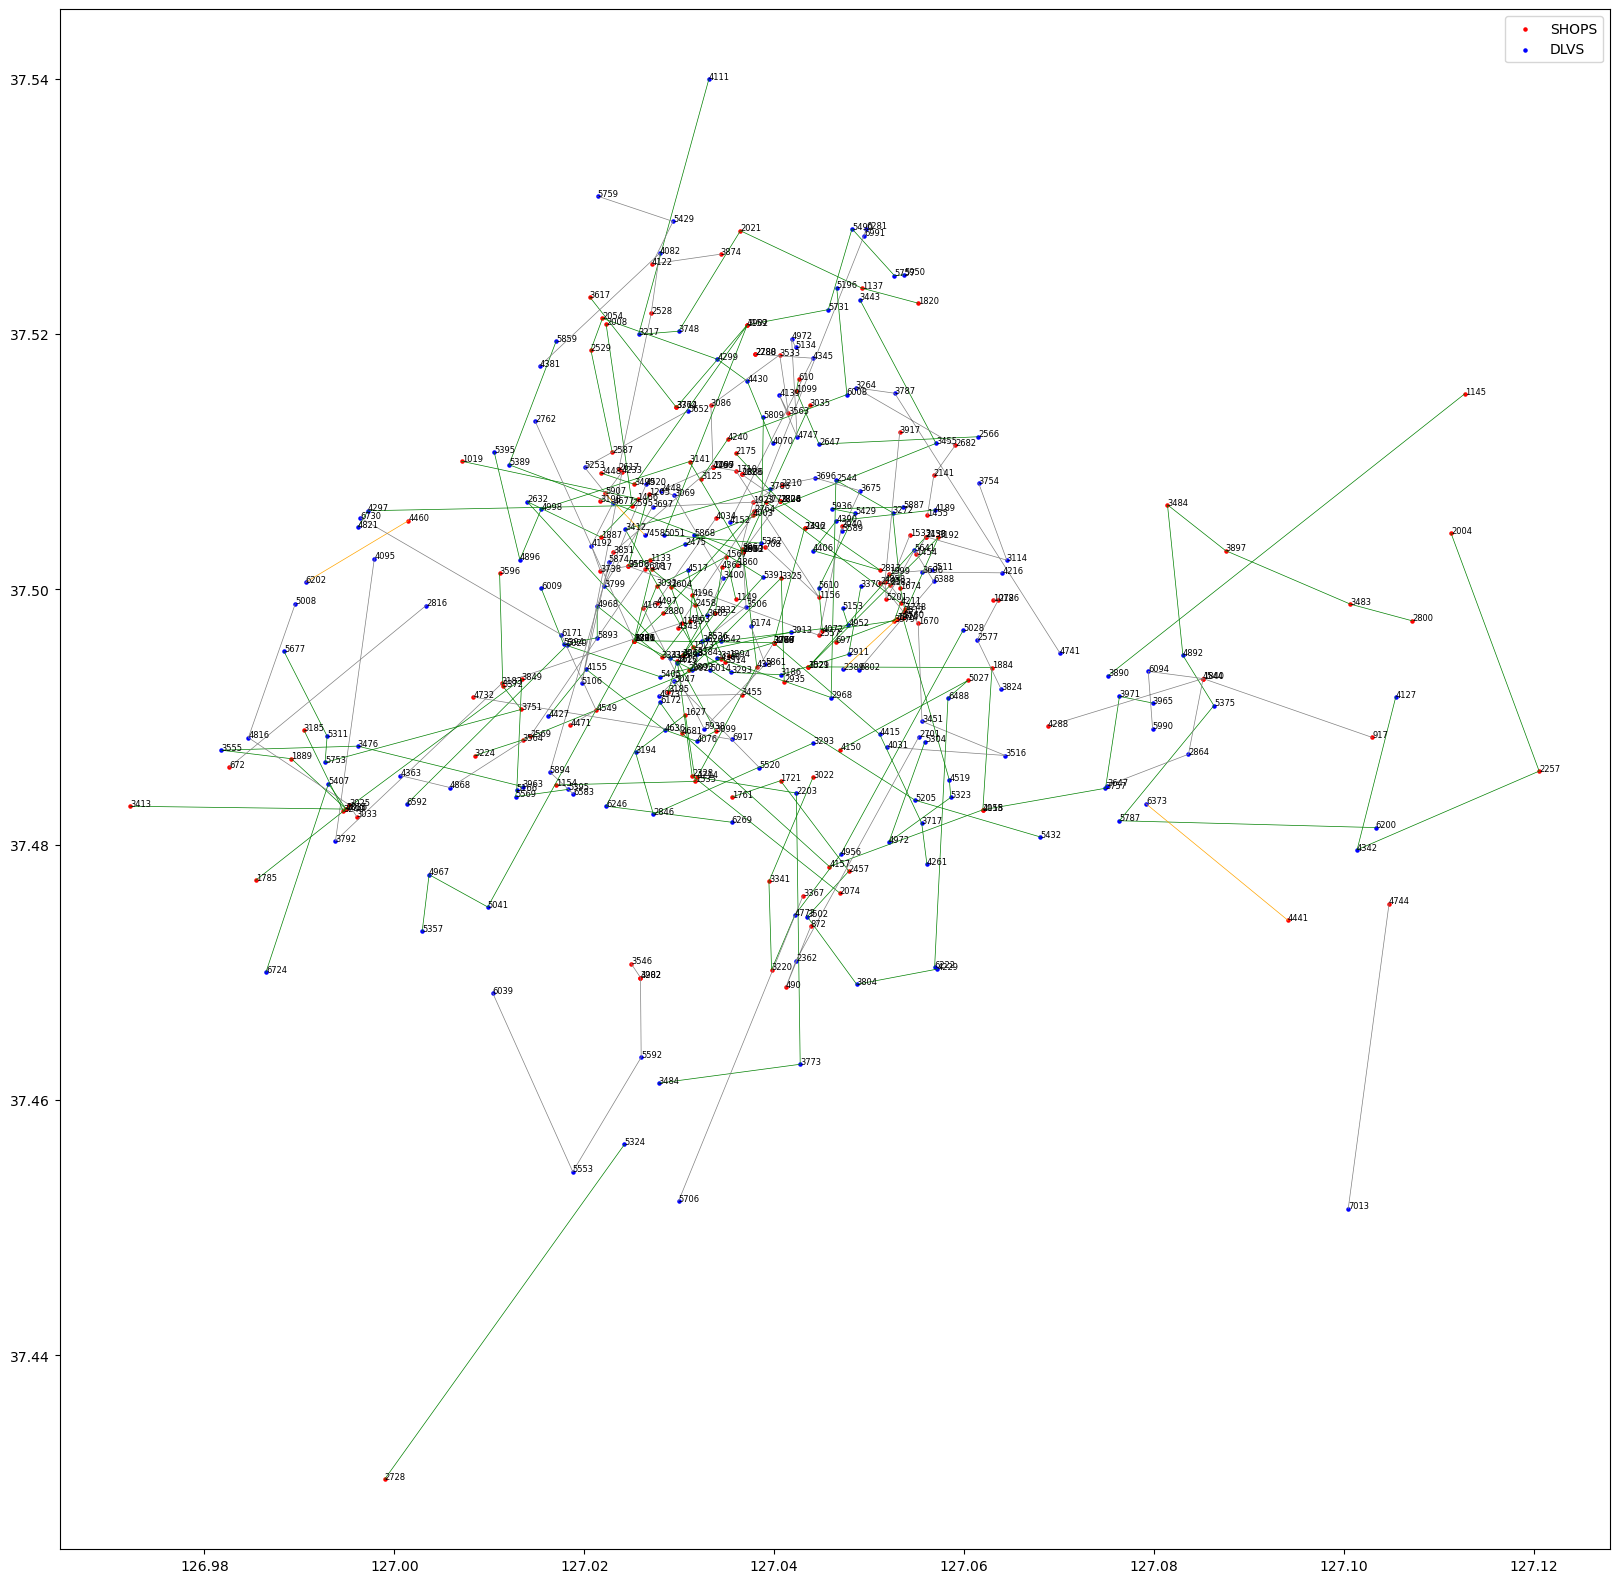

In [115]:
draw_route_solution3(ALL_ORDERS, checked_solution)

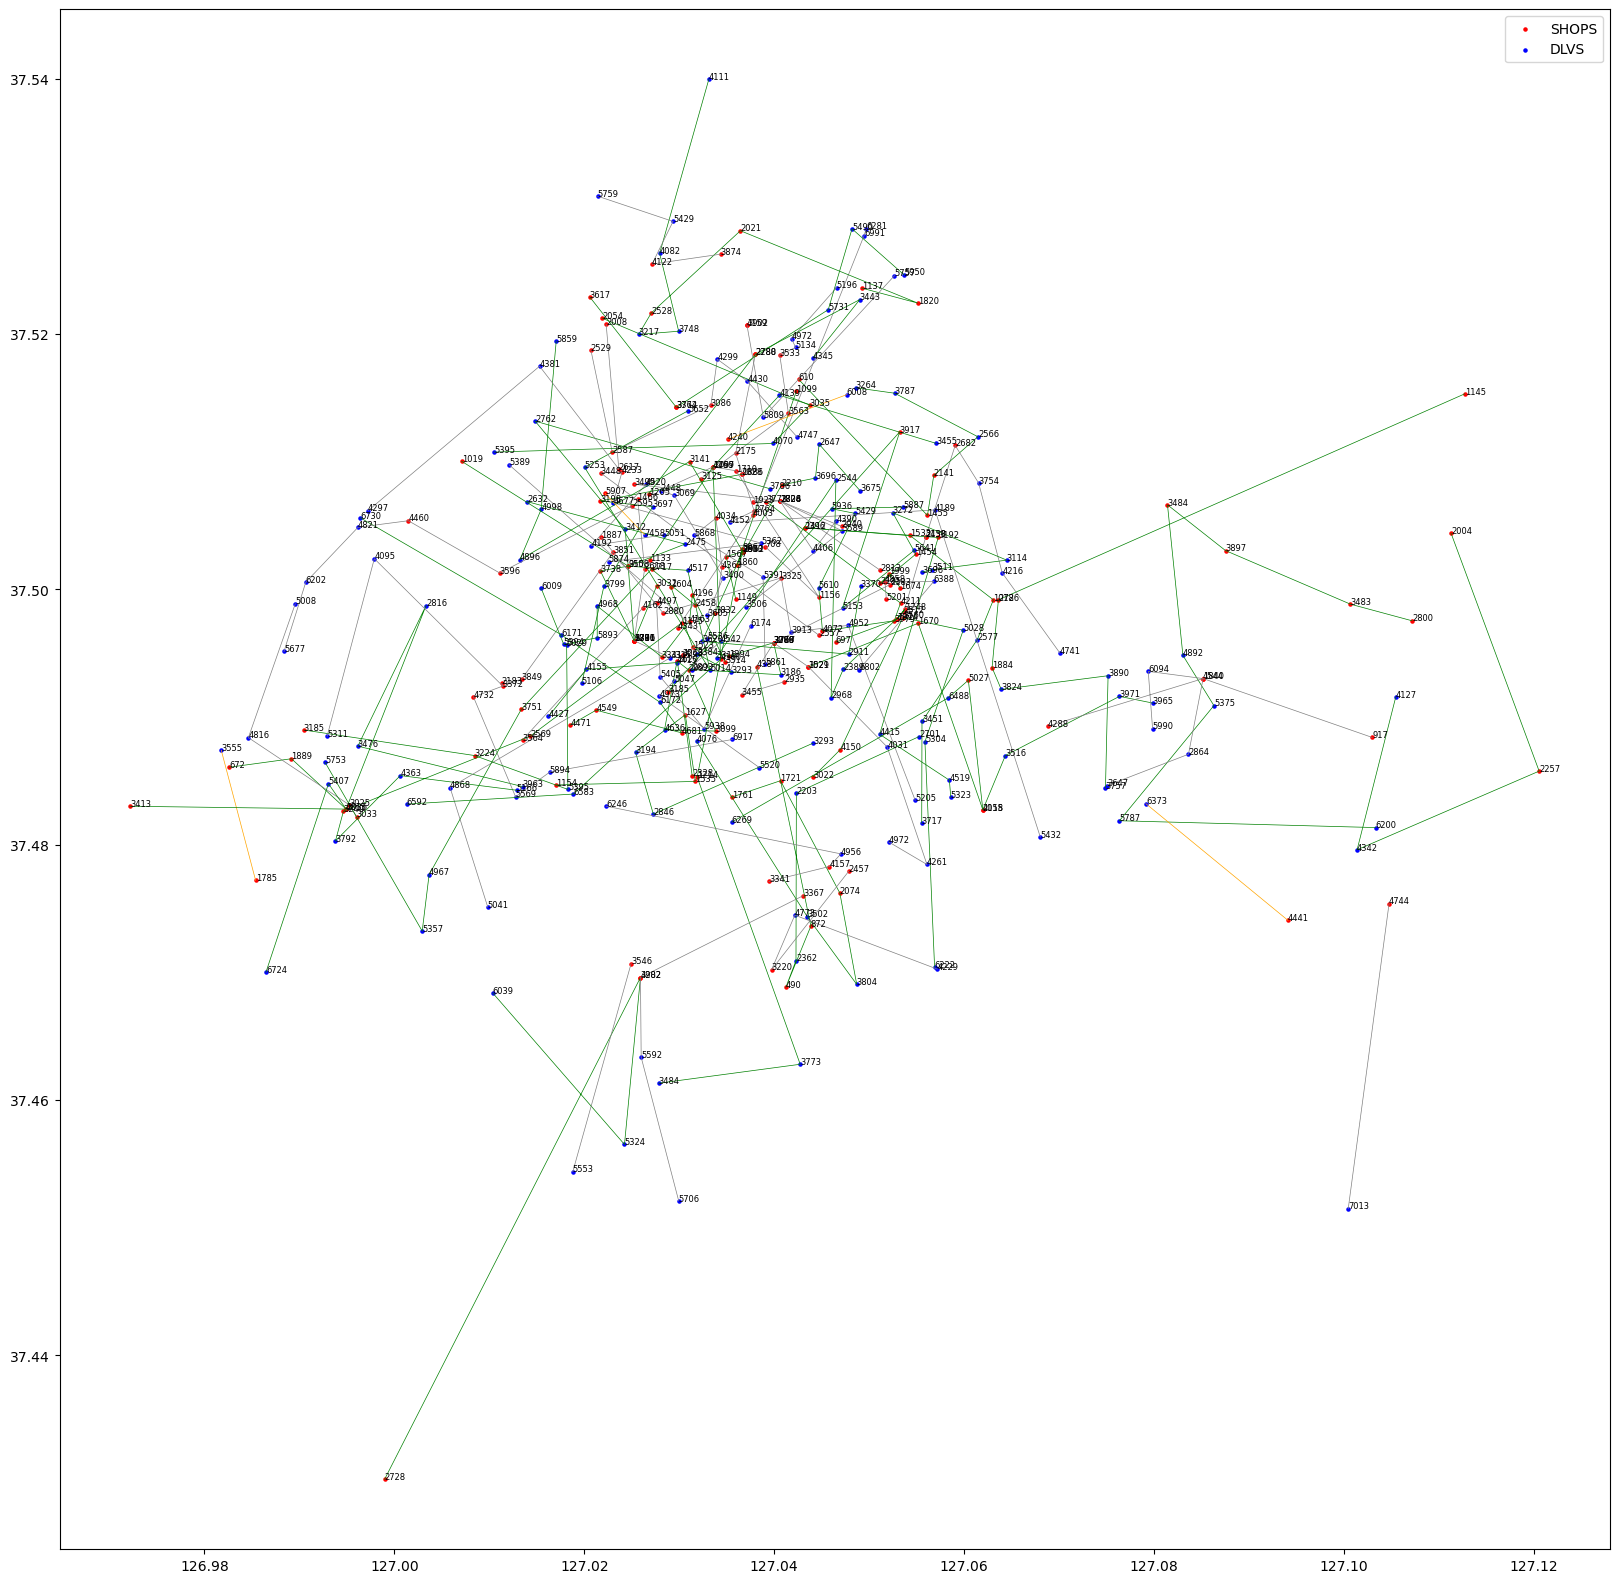

In [113]:
draw_route_solution3(ALL_ORDERS, checked_solution)